In [1]:
# Standard library imports
import time

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
from scipy import interpolate
from scipy.ndimage import generic_filter
import pandas as pd
import geopandas as gpd
import pyproj
import rasterio
from rasterio.features import rasterize
import shapefile as shp
import vtk
import os
import glob
import shutil
from shapely.geometry import Point
from scipy.spatial import distance
import pyvista as pv


# Flopy imports
import flopy
import flopy.utils
from flopy.mf6.utils.reference import SpatialReference
from flopy.utils import Raster
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
import flopy.utils.binaryfile as bf
from flopy.discretization import StructuredGrid
from flopy.modflow import ModflowStr
from flopy.modflow import ModflowRch
from flopy.utils import CellBudgetFile
from flopy.modflow import ModflowNwt
from flopy.utils.zonbud import ZoneBudget
from flopy.utils.binaryfile import CellBudgetFile


# Code purpose: import modules for a Python script
print("Modules imported successfully.")


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


In [2]:
# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe','Gondebeek_ini.hds']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

In [3]:
print(flopy.__version__)

3.6.0


Customized functions are integrated in the mod_utils.py library

In [4]:
import mod_utils
import importlib
importlib.reload(mod_utils)

<module 'mod_utils' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\mod_utils.py'>

Geometry input data

In [5]:
# Geometry
geometry_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Marylidia_data\\DEM\\DEM"
shp_Gondebeek_path = os.path.join(geometry_path,"Catchment_Gondebeek_v2.shp")
raster_DEM_path= os.path.join(geometry_path,'DEM_Gondebeek.asc')
raster_A100t_path = os.path.join(geometry_path,'A0100_t.asc')
raster_Paniseliaan_Brusseliaan_Aquifer_path=os.path.join(geometry_path,'A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc')
raster_Paniseliaan_Aquitard_path= os.path.join(geometry_path,'A0700_Paniseliaan_Aquitard.asc')    
raster_eperiaan_Aquifer_path= os.path.join(geometry_path,'A0800_Leperiaan_Aquifer.asc')    

The main working directory and model directory are defined

In [6]:
modelname = 'Gondebeek'
model_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow"

General geometrical aspects of the model are defined

In [7]:
# Load shape
shp_obj = shp.Reader(shp_Gondebeek_path)

# Read shape
feature = shp_obj.shapeRecords()[0]

# Domain extension
bbox = feature.shape.bbox
Lx = -(bbox[0]-bbox[2]) #m
Ly = -(bbox[1]-bbox[3]) #m

# Horizontal discretization
delr = 100
delc = 100

# Number of model rows, and cols
nrow = Ly / delr
ncol = Lx / delc

# Actualizar nrow y ncol
nrow = int(np.round(nrow+.5))
ncol = int(np.round(ncol+.5))

# Actualizar Lx y Ly
Ly = nrow*delr
Lx = ncol*delc

# Origins round to left and up
xul = int(bbox[0]//100*100)
yul = int((bbox[3])//100*100+100)

# Number of layers between guide layers
gls_lays = np.array([1,1,1,1])

# Total N of layers are calculated
nlay = gls_lays.sum()

Guide layer elevations are loaded and interpolated to the model grid, including top later DEM

This Python function, ```interpolate_to_grid```, is designed to interpolate data from a set of files to a model grid using the natural neighbor method:

1. **Function Signature:**
    `interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc, base_layer=None, skiprows=None)`

2. **Parameters:**
    - `file_list`: A list of input files.
    - `xul`, `yul`: The upper left coordinates of the model grid.
    - `nrow`, `ncol`: The number of rows and columns in the model grid.
    - `delr`, `delc`: The row and column spacing in the model grid.
    - `base_layer`: An optional layer that defines the base of the model.
    - `skiprows`: The number of rows to skip in the file.

3. **Process:**
    - The function first generates a model grid of (x, y) coordinates.
    - It then initializes an array to hold the interpolated data.
    - If a base layer is provided, it is added to the interpolated array.
    - The function then loops over each file in the file list.
        - It opens each file and reads its lines.
        - It gathers the characteristics of the asc file from the first 6 lines.
        - It loads the data from the asc file into a grid.
        - It generates a grid of (x, y) coordinates for the asc file.
        - It uses the `griddata` function from the `scipy.interpolate` module to interpolate the data from the asc grid to the model grid.
        - It then loops over each cell in the model grid, checking if the interpolated data is less than or equal to 0. If it is, it sets the cell value to the value from the previous layer minus 1. Otherwise, it sets the cell value to the interpolated data.

4. **Return:**
    - The function returns a 3D array with the interpolated data.

In [8]:
file_list = [raster_DEM_path,raster_A100t_path,raster_Paniseliaan_Brusseliaan_Aquifer_path,raster_Paniseliaan_Aquitard_path,raster_eperiaan_Aquifer_path]

interp_elevs = mod_utils.interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc)



In [9]:
interp_elevs[1]

array([[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]],
      dtype=float32)

Guide layer elevations are corrected so they do not cross between each other

1. **Function Signature:**
    `check_layer_elevs(elev_array, threshold=None)`

2. **Parameters:**
    - `elev_array`: A 3D array containing the layer elevation information.
    - `threshold`: An optional parameter that specifies the elevation difference to be assigned if an overlapping layer is encountered. The default value is 0.1.

3. **Process:**
    - The function first checks if a threshold is provided. If not, it sets the threshold to 0.1.
    - It then gets the dimensions of the 3D array.
    - The function loops over each layer in the array (except the first one), and for each cell in each layer, it calculates the difference in elevation between the current layer and the one above it.
    - If the difference is less than or equal to 0 (indicating an overlap), it adjusts the elevation of the current cell to be lower than the cell above it by the specified threshold.

4. **Return:**
    - The function returns the adjusted 3D array.

In [10]:
interp_elevs = mod_utils.check_layer_elevs(interp_elevs,1.01)
len(gls_lays)
len(interp_elevs)

5

Botm and topm array are generated

In [11]:
botm = np.zeros((nlay,nrow,ncol),dtype=float)
botm = mod_utils.fill_botm_array(botm,interp_elevs,gls_lays)
topm = mod_utils.fill_topm_array(botm,interp_elevs,gls_lays)


In [12]:
top=topm[0]
top

array([[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]])

Temporal discretization

In [13]:
# Fecha inicial y final
year_0 = 2015; month_0 = 1; day_0 = 1 
year_F = 2016; month_F = 1; day_F = 1 

SP = mod_utils.Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F, scale='d', n_scale=1)
perlen, fecha_inicialSP, fecha_finalSP, nstp, tsmult, steady = SP
nper = len(perlen)


Basic packages are created

In [14]:
mf2005_exe = os.path.join('MODFLOW-NWT.exe')  # Path to MODFLOW-2005 NWT executable
#noflow = mod_utils.active_cell(sim,shp_obj)
sim = flopy.modflow.Modflow(modelname=modelname, model_ws=model_dir,
                          version='mf2005', exe_name=mf2005_exe,
                          structured=True)
                          
                          
dis = flopy.modflow.ModflowDis(sim, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=interp_elevs[0], botm=botm,
                              xul=xul, yul=yul, nper=nper,steady=steady,
                               perlen=perlen,nstp=nstp,tsmult=tsmult)

lpf = flopy.modflow.ModflowLpf(sim, ipakcb=50, hk=500, laytyp=4, layvka=1, laywet=1, wetdry=-0.01, iwetit=100, ihdwet=1)
# Write BAS package
# Convert the Util3d object to a numpy array

noflow = mod_utils.active_cell(sim,shp_obj)
# Create a mask where botm and top are not NaN
mask = np.logical_and(~np.isnan(botm), ~np.isnan(top))

# Create an IBOUND array based on the mask
ibound = np.where(mask, 1, 0)

# Use this IBOUND array to create the ModflowBas object
bas = flopy.modflow.ModflowBas(sim, strt=interp_elevs[0], ibound=noflow)
botm_array = dis.botm.array


# # Change  -1e9 to zero
# botm_array[botm_array <= -1.000000E+09] = 0

# # Convert the numpy array back to a Util3d object
# dis.botm = flopy.utils.Util3d(sim, botm_array.shape, np.float32, botm_array, name='botm', locat=dis.unit_number[0])
# # Write the modified DIS package back to the model

# # Convert the Util2d object to a numpy array
# top_array = dis.top.array

# # Change -1e9 top elevations to zero
# top_array[top_array <=-1.000000E+09] = 0

# # Convert the numpy array back to a Util2d object
# dis.top = flopy.utils.Util2d(sim, top_array.shape, np.float32, top_array, name='top', locat=dis.unit_number[0])

# bas.write_file()

# Get the number of stress periods from the DIS package
nstress = sim.dis.nper

# Define the OC stress period data
oc_spd = {(i, 17): ['save head', 'save budget'] for i in range(0, 366)}

# Create the OC package
oc = flopy.modflow.ModflowOc(sim, stress_period_data=oc_spd, compact=True)
oc.iuhead = 51  # Assign a unit number to the head file

# Write the OC package
oc.write_file()
sim.write_input()


In [15]:
noflow[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

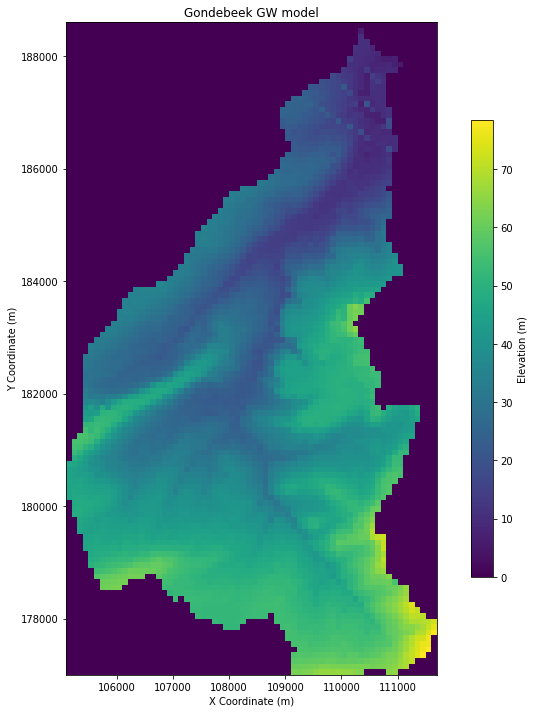

In [16]:

# Get the top layer of the model
top_layer = sim.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = 0, top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=sim)

# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Plot the grid and inactive cells
#linecollection = modelmap.plot_grid()
#quadmesh = modelmap.plot_ibound(ibound=noflow, color_noflow='cyan')

# Add a colorbar with a label
cbar = plt.colorbar(quadmesh, shrink=0.7)
cbar.set_label('Elevation (m)')

# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()


Get the initial head from Pseudo_SS

In [18]:
import flopy.utils.binaryfile as bf
import flopy.modflow as mf

# Load the head data from the first model
headobj = bf.HeadFile('C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\Gondebeek_ini.hds')
head = headobj.get_data()

# Extract the head data from the last stress period
last_sp_heads = head[-1]

# Load the second model
model = mf.Modflow.load('Gondebeek.nam')  # Replace 'Gondebeek_SS.nam' with the path to your name file

# Remove the existing BAS package
model.remove_package('BAS6')

# Create a new BAS package with the updated initial heads
bas = mf.ModflowBas(model, strt=last_sp_heads)

# Write the updated model to a new set of files
model.write_input()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


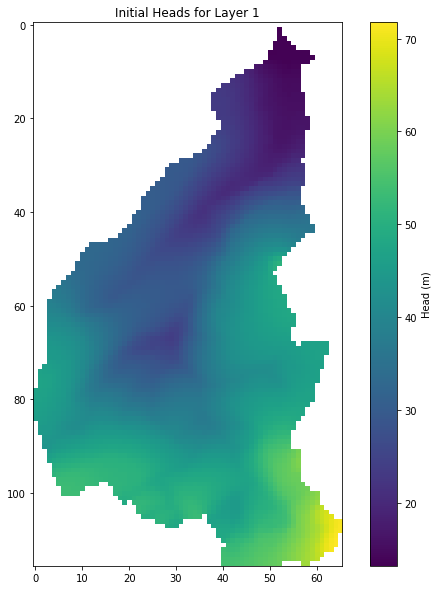

In [20]:
import flopy.modflow as mf

# Load the model
model = mf.Modflow.load('Gondebeek.nam')  # Replace 'model.nam' with the path to your name file

# Get the BAS package
bas = model.get_package('BAS6')

# Get the initial heads
initial_heads = bas.strt.array

# Mask values lower than -900
initial_heads = np.ma.masked_where(initial_heads < -900, initial_heads)

# Plot the initial heads for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(initial_heads[0, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Initial Heads for Layer 1')
plt.show()

In [21]:
sim.check()


Gondebeek MODEL DATA VALIDATION SUMMARY:
  1 Error:
    No solver package
  1 Warning:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: zero or negative specific storage 

Export hk to SHP for comparison with input data

In [22]:
# Set the layer index
layer_index = 0

# Retrieve the hydraulic conductivity array for the desired layer
hk_array = sim.lpf.hk.array[layer_index]

# Set inactive cells to NaN
ibound = noflow
active_cells = ibound > 0
hk_layer = hk_array[noflow[layer_index]>0]

# Define the coordinate reference system
crs1 = pyproj.CRS("EPSG:31370")

fname="hk.shp"
sim.lpf.hk.export(fname,crs=crs1,write_prj="31370.prj")

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


### Get shapefile of K and s

In [23]:
# Load the shapefile for K and s:
k_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_k_clipped.shp"
s_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_s_clipped.shp"
k = gpd.read_file(k_path)
s = gpd.read_file(s_path)
# Print the attributes of the shapefile
print(k.columns)
print(s.columns)

Index(['node', 'row', 'column', 'icellpe_1_', 'icellpe_2_', 'icellpe_3_',
       'icellpe_4_', 'icellpe_5_', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k33_1',
       'k33_2', 'k33_3', 'k33_4', 'k33_5', 'geometry'],
      dtype='object')
Index(['node', 'row', 'column', 'iconvert_1', 'iconvert_2', 'iconvert_3',
       'iconvert_4', 'iconvert_5', 'ss_1', 'ss_2', 'ss_3', 'ss_4', 'ss_5',
       'sy_1', 'sy_2', 'sy_3', 'sy_4', 'sy_5', 'geometry'],
      dtype='object')


In [24]:
import mod_utils
import importlib
importlib.reload(mod_utils)

<module 'mod_utils' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\mod_utils.py'>

In [25]:
#set hydraulic properties:
mod_utils.set_hydraulic_properties(sim, k, s, bbox, delr, delc, ['k_1', 'k_2', 'k_3', 'k_3'], 
                                   ['k33_1', 'k33_2', 'k33_3', 'k33_3'],['sy_1', 'sy_2', 'sy_3', 'sy_3'], ['ss_1', 'ss_2', 'ss_3', 'ss_3'] )
#write lpf package 

sim.lpf.write_file()

In [26]:
sim.lpf.check()


LPF PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    negative horizontal anisotropy values
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield values below checker threshold of 0.01
    specific yield values above checker threshold of 0.5



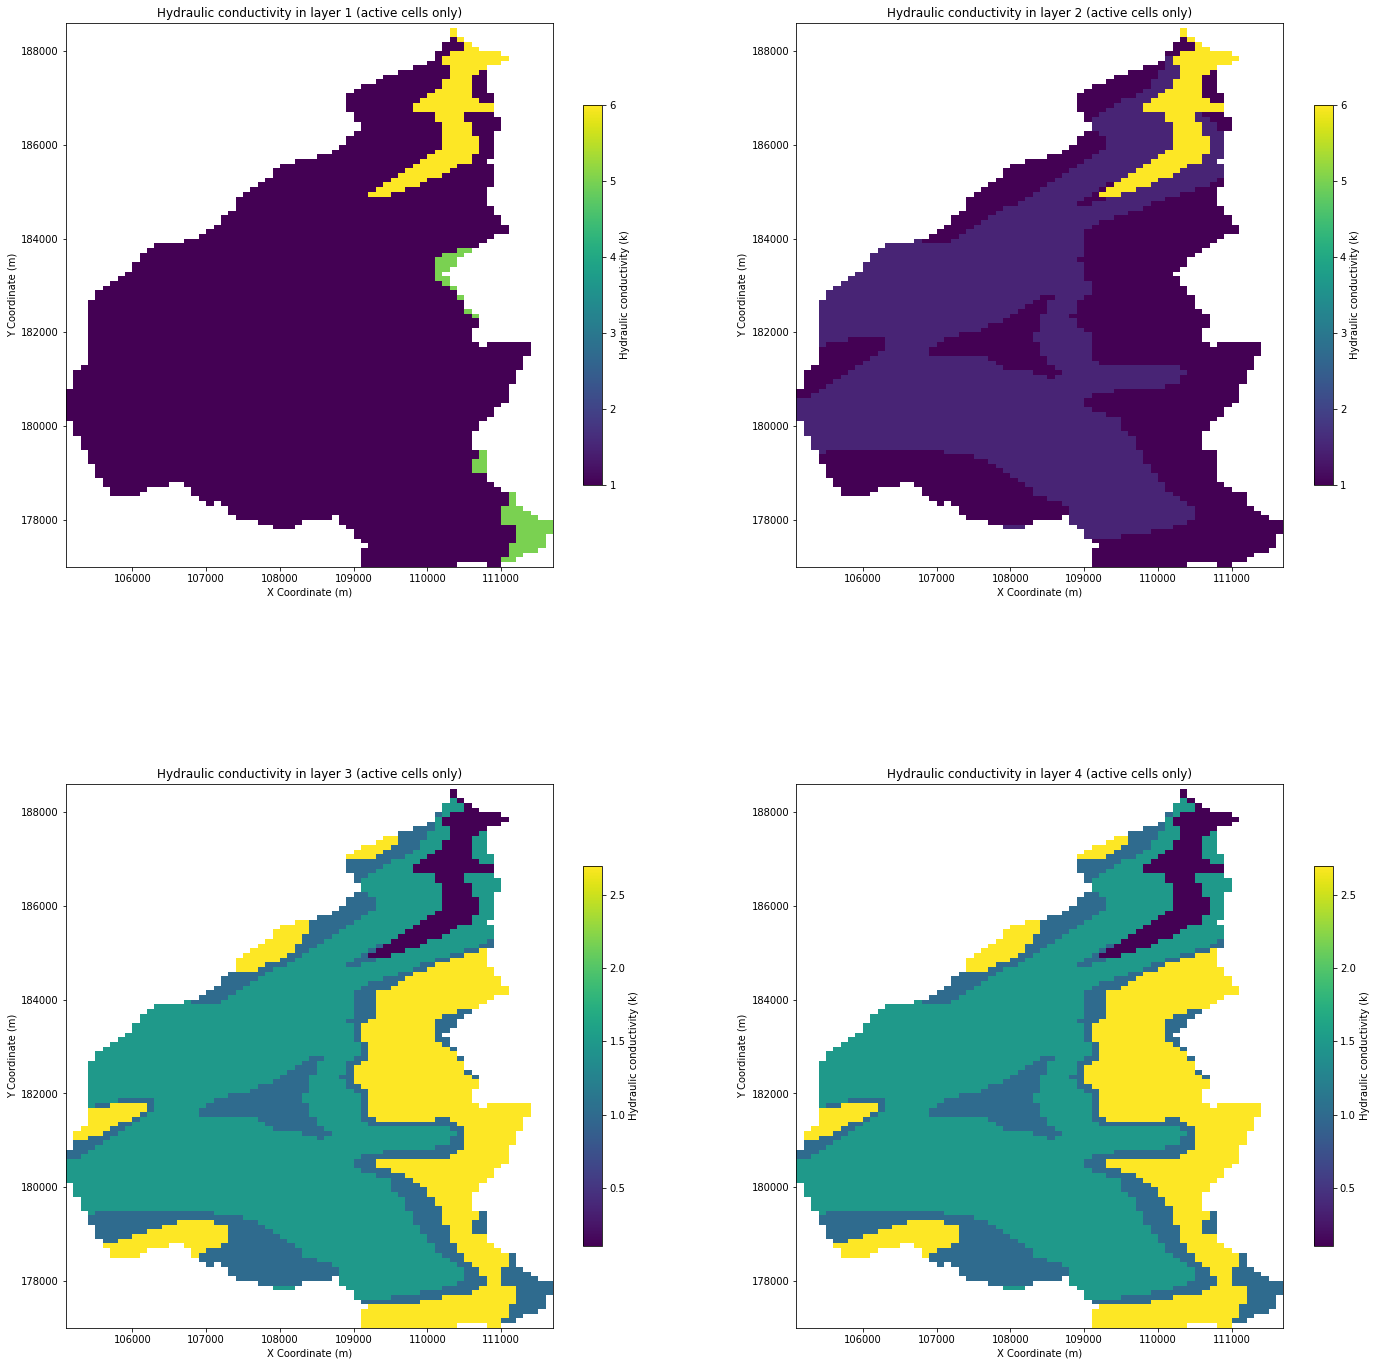

In [27]:

# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(24, 24))

for i in range(4):
    # Get the hydraulic conductivity 'k' in layer i
    k_layer = sim.lpf.hk.array[i]

    # Get the active cells in layer i 
    ibound_layer = sim.bas6.ibound.array[i]
    active_cells = ibound_layer > 0

    # Mask the 'k' array with the active cells
    k_layer_active = np.where(active_cells, k_layer, np.nan)

    # Create a map of the model
    row = i // 2
    col = i % 2
    modelmap = flopy.plot.PlotMapView(model=sim, ax=axs[row, col])

    # Plot the 'k' values of the active cells in layer i
    quadmesh = modelmap.plot_array(k_layer_active, cmap='viridis')

    # Add a colorbar with a label
    cbar = plt.colorbar(quadmesh, shrink=0.7, ax=axs[row, col])
    cbar.set_label('Hydraulic conductivity (k)')

    # Add labels to the x and y axes
    axs[row, col].set_xlabel('X Coordinate (m)')
    axs[row, col].set_ylabel('Y Coordinate (m)')

    # Add a title
    axs[row, col].set_title(f"Hydraulic conductivity in layer {i+1} (active cells only)")

# Adjust the space between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Save the plot as a PNG file
plt.savefig('Hydraulic_conductivity_all_layers.png')

# Show the plot
plt.show()



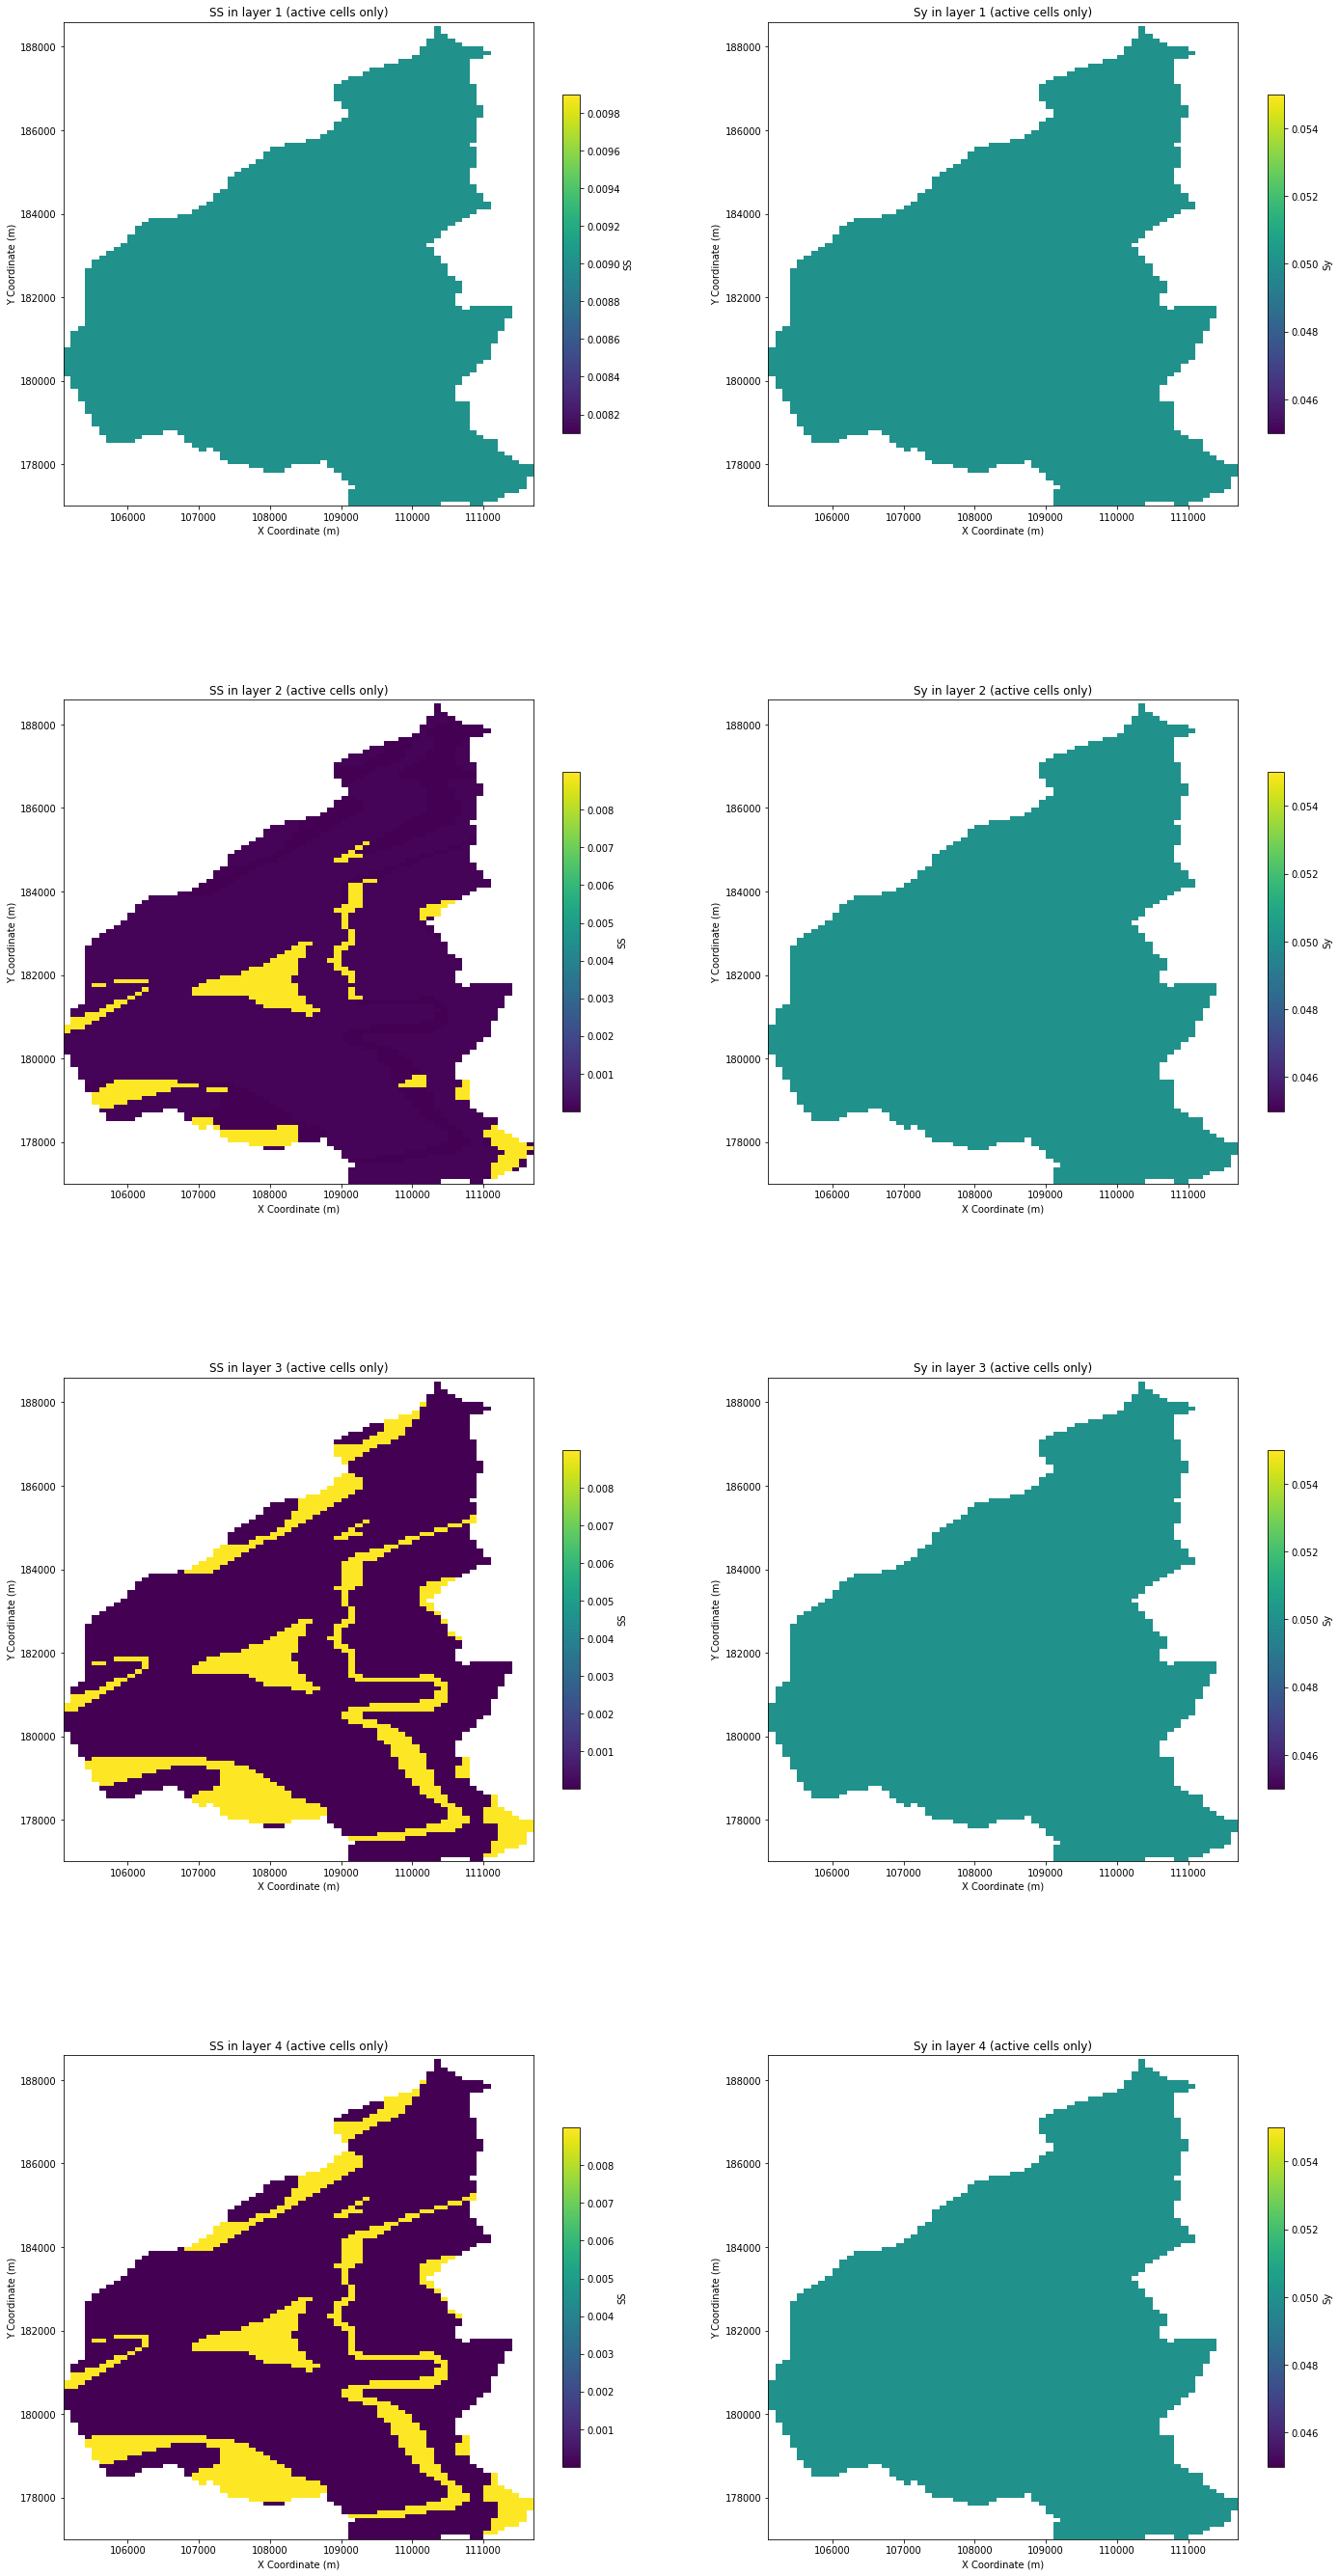

In [28]:
# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(24, 48))

for i in range(4):
    # Get the SS and Sy in layer i
    ss_layer = sim.lpf.ss.array[i]
    sy_layer = sim.lpf.sy.array[i]

    # Get the active cells in layer i 
    ibound_layer = sim.bas6.ibound.array[i]
    active_cells = ibound_layer > 0

    # Mask the 'ss' and 'sy' arrays with the active cells
    ss_layer_active = np.where(active_cells, ss_layer, np.nan)
    sy_layer_active = np.where(active_cells, sy_layer, np.nan)

    # Create a map of the model
    modelmap_ss = flopy.plot.PlotMapView(model=sim, ax=axs[i, 0])
    modelmap_sy = flopy.plot.PlotMapView(model=sim, ax=axs[i, 1])

    # Plot the 'ss' and 'sy' values of the active cells in layer i
    quadmesh_ss = modelmap_ss.plot_array(ss_layer_active, cmap='viridis')
    quadmesh_sy = modelmap_sy.plot_array(sy_layer_active, cmap='viridis')

    # Add a colorbar with a label
    cbar_ss = plt.colorbar(quadmesh_ss, shrink=0.7, ax=axs[i, 0])
    cbar_sy = plt.colorbar(quadmesh_sy, shrink=0.7, ax=axs[i, 1])
    cbar_ss.set_label('SS')
    cbar_sy.set_label('Sy')

    # Add labels to the x and y axes
    axs[i, 0].set_xlabel('X Coordinate (m)')
    axs[i, 0].set_ylabel('Y Coordinate (m)')
    axs[i, 1].set_xlabel('X Coordinate (m)')
    axs[i, 1].set_ylabel('Y Coordinate (m)')

    # Add a title
    axs[i, 0].set_title(f"SS in layer {i+1} (active cells only)")
    axs[i, 1].set_title(f"Sy in layer {i+1} (active cells only)")

# Adjust the space between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Save the plot as a PNG file
plt.savefig('SS_Sy_all_layers.png')

# Show the plot
plt.show()

In [29]:
#now an average recharge data is added for all Sp's this must be changed in the future

# Calculate the daily recharge rate in meters per day
recharge_rate = 0.0019902180502591182 /3  # Convert from mm/year to m/day (and the third part only is infiltrated)

# Create a 2D array with the recharge rate

recharge_array = [[recharge_rate for _ in range(ncol)] for _ in range(nrow)]

# Create a dictionary with the recharge rate for each stress period
nper = sim.dis.nper
recharge = {kper: recharge_array for kper in range(nper)}

# Create the recharge package
rch = flopy.modflow.ModflowRch(sim, rech=recharge,ipakcb=50)

# Write the package
rch.write_file()


### River data

In [30]:
#First: Clip river shapefile (WLas):

river_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Streams\\Shapefile"
shp_river = os.path.join(river_path,"Wlas.shp")


# Load your polygon and line shapefiles
polygon = gpd.read_file(shp_Gondebeek_path)
line = gpd.read_file(shp_river)

# Reproject the line GeoDataFrame to match the CRS of the polygon GeoDataFrame
line = line.to_crs(polygon.crs)

# Perform the clip operation
clipped = gpd.clip(line, polygon)

shp_river_clipped = os.path.join(river_path,"Wlas_clipped.shp")
# Save the clipped part to a new shapefile
clipped.to_file(shp_river_clipped)

In [31]:
from rtree import index
import geopandas as gpd
from shapely.geometry import Polygon

# Get the top elevation array and active cell data from your model
top_elev = sim.dis.top.array
ibound = sim.bas6.ibound.array  # get the array of active cells

clipped = gpd.read_file(shp_river_clipped)
layer = 0  # layer number (only layer 1)
# Create a spatial index
idx = index.Index()

# Populate spatial index with bounding boxes of active cells
for row in range(sim.modelgrid.nrow):
    for col in range(sim.modelgrid.ncol):
        if ibound[layer, row, col] > 0:
            x_center = sim.modelgrid.xcellcenters[row, col]
            y_center = sim.modelgrid.ycellcenters[row, col]
            dx = sim.modelgrid.delc[row] / 2
            dy = sim.modelgrid.delr[col] / 2
            bounds = (x_center - dx, y_center - dy, x_center + dx, y_center + dy)
            idx.insert((row * sim.modelgrid.ncol) + col, bounds)

# Initialize the segment and reach numbers
segment = 1
reach = 1
flow = 1


# Convert the shapefile to a list of [layer, row, column, segment, reach, flow, strhc1, strtop, slope, strthick, width, rough] for each reach
stream_data = []
processed_cells = set()  # Set to keep track of processed cells

for index, data in clipped.iterrows():
    # Get the vertices of the LineString
    vertices = list(data['geometry'].coords)
    
    for i in range(len(vertices) - 1):
        # Calculate the minimum and maximum x and y coordinates
        minx = min(vertices[i][0], vertices[i+1][0])
        miny = min(vertices[i][1], vertices[i+1][1])
        maxx = max(vertices[i][0], vertices[i+1][0])
        maxy = max(vertices[i][1], vertices[i+1][1])
        
        # Get intersecting cells using spatial index
        coordinates = (minx, miny, maxx, maxy)
        intersecting_cells = list(idx.intersection(coordinates))
        
        if not intersecting_cells:
            continue
        
        # Process only the intersecting active cells
        for cell_index in intersecting_cells:
            row = cell_index // sim.modelgrid.ncol
            col = cell_index % sim.modelgrid.ncol
            
            # Skip the specific cells
            if (row, col) in [(1, 52), (6, 58)]:
                continue
            
            # Skip if the cell has already been processed
            if (row, col) in processed_cells:
                continue
            
            layer = 0  # layer number (only layer 1)
            # Check if the cell is within the active domain
            if ibound[layer, row, col] > 0:
                # Calculate the reach length as the distance between the centers of the cells
                next_row, next_col = sim.modelgrid.intersect(vertices[i+1][0], vertices[i+1][1])
                # Check if the next cell is within the active domain
                if ibound[layer, next_row, next_col] > 0:
                    rchlen = ((sim.modelgrid.xcellcenters[row, col] - sim.modelgrid.xcellcenters[next_row, next_col])**2 + 
                              (sim.modelgrid.ycellcenters[row, col] - sim.modelgrid.ycellcenters[next_row, next_col])**2)**0.5
                    strtop = top_elev[row, col]  # streambed top (top elevation of the cell)
                    slope = 0.001  # stream slope (using a small constant value for now)
                    strthick = 1.0  # streambed thickness
                    strhc1 = 1.0  # streambed conductance
                    stage = 1.0  # initial stream stage
                    width = 1.0  # stream width
                    rough = 1.0  # roughness coefficient
                    stream_data.append([layer, row, col, segment, reach, flow, strhc1, stage, strtop, slope, strthick, width, rough])
                    reach += 1  # increment the reach number
                    processed_cells.add((row, col))  # Add the cell to the set of processed cells

    segment += 1  # increment the segment number
    reach = 1  # reset the reach number for the next segment

# Get the number of stress periods
nstress = sim.dis.nper

# Define the stream reach data for the first stress period
stress_period_data = {0: stream_data}

# Replicate the first stress period data for all stress periods
for i in range(1, nstress):
    stress_period_data[i] = stress_period_data[0]

# Define some default segment data
segment_data = {i: [[1]*11 for _ in range(len(stream_data))] for i in range(nstress)}

# Create the STR package
str = flopy.modflow.ModflowStr(sim, mxacts=len(stream_data), nss=len(stream_data), stress_period_data=stress_period_data, segment_data=segment_data, istcb2=0, ipakcb=50, options=['FLOW'])

# Write the package
str.write_file()

str.check()


STR PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



In [32]:
# Print the row and column of each stream cell
for data in stream_data:
    layer, row, col, segment, reach, flow, strhc1, stage, strtop, slope, strthick, width, rough = data
    print(f"Stream cell at layer {layer}, row {row}, column {col}")

Stream cell at layer 0, row 111, column 50
Stream cell at layer 0, row 112, column 50
Stream cell at layer 0, row 111, column 51
Stream cell at layer 0, row 110, column 51
Stream cell at layer 0, row 110, column 52
Stream cell at layer 0, row 109, column 52
Stream cell at layer 0, row 109, column 53
Stream cell at layer 0, row 108, column 53
Stream cell at layer 0, row 108, column 52
Stream cell at layer 0, row 107, column 53
Stream cell at layer 0, row 107, column 54
Stream cell at layer 0, row 106, column 53
Stream cell at layer 0, row 108, column 61
Stream cell at layer 0, row 107, column 61
Stream cell at layer 0, row 107, column 62
Stream cell at layer 0, row 108, column 62
Stream cell at layer 0, row 108, column 60
Stream cell at layer 0, row 107, column 60
Stream cell at layer 0, row 108, column 59
Stream cell at layer 0, row 108, column 58
Stream cell at layer 0, row 109, column 58
Stream cell at layer 0, row 109, column 57
Stream cell at layer 0, row 108, column 49
Stream cell

Exporting to SHP

In [33]:
import geopandas as gpd
from shapely.geometry import Polygon

# Get the stream data from the STR package
stream_data = sim.str.stress_period_data[0]

# Create a list to store the polygons
polygons = []

# Loop through the stream data and create a Polygon for each stream cell
for data in stream_data:
    layer, row, col, stage, conductance, bottom, top, width, slope, roughness, *rest = data
    x = sim.modelgrid.xcellcenters[row, col]
    y = sim.modelgrid.ycellcenters[row, col]
    dx = sim.modelgrid.delc[row] / 2
    dy = sim.modelgrid.delr[col] / 2
    polygons.append(Polygon([(x-dx, y-dy), (x-dx, y+dy), (x+dx, y+dy), (x+dx, y-dy)]))

# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS of the GeoDataFrame to Belgian Lambert 72
gdf.crs = 'EPSG:31370'

# Define the output path
output_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Streams\Shapefile\stream_cells.shp"

# Export the GeoDataFrame as a shapefile
gdf.to_file(output_path)



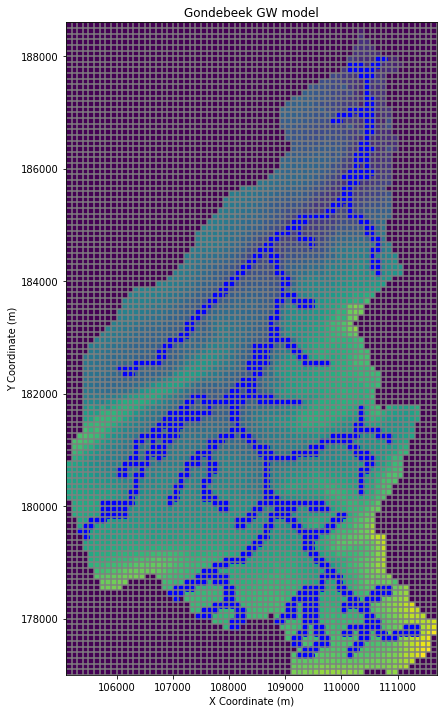

In [34]:
# Load the clipped river shapefile
clipped_river = gpd.read_file(shp_river_clipped)

# Get the top layer of the model
top_layer = sim.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = 0, top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=sim)


# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Get the stream data from the STR package
stream_data = sim.str.stress_period_data[0]

# Plot the stream cells
for data in stream_data:
    layer, row, col, stage, conductance, bottom, top, width, slope, roughness, *rest = data
    x = sim.modelgrid.xcellcenters[row, col]
    y = sim.modelgrid.ycellcenters[row, col]
    ax.plot(x, y, 'bo')  # 'bo' means blue circle

# Plot the grid lines
modelmap.plot_grid()

# Plot the clipped river shapefile first
clipped_river.plot(ax=ax, color='none', edgecolor='black')


# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()


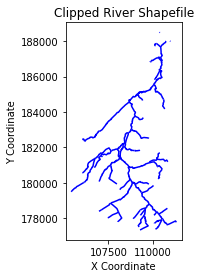

In [35]:
clipped_river = gpd.read_file(shp_river_clipped)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the shapefile
clipped_river.plot(ax=ax, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Clipped River Shapefile')

# Show the plot
plt.show()

In [36]:
# # Define the evaporation rate
# evtr_value = 0.00163906717512467 * 0.2

# # Assign the evaporation rate to all time steps
# evtr = {kper: evtr_value for kper in range(sim.nper)}

# # Create the EVT package
# evt = flopy.modflow.ModflowEvt(sim, nevtop=1, evtr=evtr, ipakcb=50)

# # Add the EVT package to the MODFLOW model
# sim.add_package(evt)

# evt.write_file()
# sim.write_input()

In [37]:
sim.write_input()

In [38]:
# Check if the PCG package exists before trying to remove it
if 'PCG' in sim.get_package_list():
    sim.remove_package('PCG')


# pcg = flopy.modflow.ModflowPcg(sim, 
#                                mxiter=5000,  # Increase the maximum number of outer iterations
#                                iter1=100,  # Increase the maximum number of inner iterations
#                                npcond=2,
#                                nbpol=2,# Use Modified Incomplete Cholesky preconditioning
#                                hclose=5e-02,  # Decrease the head change criterion for convergence
#                                rclose=5e-02,  # Decrease the residual criterion for convergence
#                                relax=0.96,  # Slightly increase the relaxation parameter  # Use Polak-Ribiere preconditioning
#                                iprpcg=1,  # Use an optional modified incomplete Cholesky preconditioning
#                                mutpcg=3,  # Control printing of convergence information from the solver
#                                damp=0.97)  # Slightly increase the damping factor
# pcg.write_file()
# # Add OC package to the model
# sim.add_package(oc)
# sim.add_package(pcg)

### From this cell and below, we will load the created model and run it.

In [39]:
# Load the model
sim = flopy.modflow.Modflow.load('Gondebeek.nam')

# Change the version to 'mfnwt'
sim.version = 'mfnwt'

# Check if the PCG package exists before trying to remove it
if 'PCG' in sim.get_package_list():
    sim.remove_package('PCG')

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')

# Check if the LPF package exists before trying to remove it
if 'LPF' in sim.get_package_list():
    lpf = sim.get_package('LPF')
else:
    # Try to load the LPF package from a file
    lpf_file = 'Gondebeek.lpf'
    if os.path.exists(lpf_file):
        lpf = flopy.modflow.ModflowLpf.load(lpf_file, sim)
    else:
        print("LPF package does not exist in the model or in the file. Cannot create UPW package.")
        lpf = None

if lpf is not None and hasattr(lpf, 'hk'):
    sim.remove_package('LPF')
    # Create a new UPW package with the same parameters as the LPF package
    upw = flopy.modflow.ModflowUpw(sim, hk=lpf.hk.array, 
                                   vka=lpf.vka.array, 
                                   sy=lpf.sy.array, 
                                   ss=lpf.ss.array, 
                                   laytyp=lpf.laytyp.array,
                                   ipakcb=50)
    # Add the new UPW package to the model
    sim.add_package(upw)
else:
    print("LPF package does not have 'hk' attribute. Cannot create UPW package.")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 31 of package UPW already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UPW' package.
  warn(


In [40]:

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')
# Create a new NWT solver with custom parameters
nwt = flopy.modflow.ModflowNwt(sim, 
                               headtol=0.001, 
                               fluxtol=700, 
                               maxiterout=4000, 
                               thickfact=1e-7, 
                               linmeth=2, 
                               iprnwt=1, 
                               ibotav=0, 
                               dbdtheta=0.8, 
                               dbdkappa=0.4, 
                               dbdgamma=0.5, 
                               momfact=0.05, 
                               backflag=1, 
                               maxbackiter=400, 
                               backtol=1.5, 
                               backreduce=0.9, 
                               iacl=2, 
                               norder=1, 
                               level=6, 
                               north=4, 
                               iredsys=1, 
                               rrctols=0.0, 
                               idroptol=1, 
                               epsrn=1e-3, 
                               hclosexmd=1e-3, 
                               mxiterxmd=250,
                               Continue=False,
                               options='SPECIFIED')

# Add the new NWT package to the model
sim.add_package(nwt)

# Set the path to the MODFLOW-NWT executable
sim.exe_name = 'MODFLOW-NWT.exe'

# Write the entire model to disk
sim.write_input()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 32 of package NWT already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'NWT' package.
  warn(


In [41]:
# Run the model
sim.run_model()

FloPy is using the following executable to run the model: MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: Gondebeek.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/28 12:35:38

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.
 Solving:  S

(True, [])

## Results

Create a zone file matching the active area with zone 1, and the inactive area with zone 2.

In [2]:
# Load the model
modelname = 'Gondebeek'  # replace with your model name if different
mf = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the ibound array from the bas package of the model
ibound = mf.bas6.ibound.array


# Assuming 'ibound' is a 3D array with shape (nlay, nrow, ncol)
# Create a new array for zones
zones = np.full_like(ibound, 2)

# Set active cells to 1
zones[ibound > 0] = 1

# Save the zones to a .zone file with a header for each layer
with open('zones.zone', 'w') as zone_file:
    for i in range(zones.shape[0]):
        zone_file.write('INTERNAL 1 (FREE) -1\n')
        np.savetxt(zone_file, zones[i], fmt='%d')

Create a zone file with all the model as one file.

In [3]:


modelname = 'Gondebeek'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the ibound array from the bas package of the model
ibound = sim.bas6.ibound.array


# Assuming 'ibound' is your ibound array
# Create the zone array from the ibound array
z = np.where(ibound == 0, 1, ibound)

# 'Gondebeek.cbc' is your cell-by-cell budget file
cbc = CellBudgetFile('Gondebeek.cbc')

# Get the kstpkper from the cell budget file
kstpkper = cbc.get_kstpkper()

# Create the ZoneBudget object
zb = ZoneBudget('Gondebeek.cbc', z=z, kstpkper=kstpkper)


# Get the budget for all records and zone 1
budget_zone1 = zb.get_budget()

In [4]:
from flopy.utils import ZoneBudget, CellBudgetFile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the model
modelname = 'Gondebeek'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the ibound array from the bas package of the model
ibound = sim.bas6.ibound.array

# Create the zone array from the ibound array
zon = np.where(ibound == 0, 1, ibound)

# Get the cell-by-cell budget file name from the model
cbc_file = f"{modelname}.cbc"

# Create a CellBudgetFile object
cbc = CellBudgetFile(cbc_file)

# Get the kstpkper from the cell budget file
kstpkper = cbc.get_kstpkper()

# Create a ZoneBudget object
zb = ZoneBudget(cbc_file, zon, kstpkper=kstpkper)

# Get the budget record array
budget = zb.get_budget()

# Save the budget to a CSV file
f_out = f"{modelname}_output.csv"
zb.to_csv(f_out)

# # Plot the zones
# nlay, nrow, ncol = zon.shape
# fig = plt.figure(figsize=(10, 4))

# for lay in range(nlay):
#     ax = fig.add_subplot(1, nlay, lay + 1)
#     im = ax.pcolormesh(zon[lay, ::-1, :])
#     cbar = plt.colorbar(im)
#     plt.gca().set_aspect("equal")

# plt.show()

# Print the contents of the CSV file
print(pd.read_csv(f_out).to_string(index=False))

     totim  time_step  stress_period                name        ZONE_1
  1.000000         17              0        FROM_STORAGE 147707.900000
  1.000000         17              0  FROM_CONSTANT_HEAD      0.000000
  1.000000         17              0       FROM_RECHARGE  28844.887000
  1.000000         17              0 FROM_STREAM_LEAKAGE      0.000000
  1.000000         17              0         FROM_ZONE_1      0.000000
  1.000000         17              0            TOTAL_IN 176552.800000
  1.000000         17              0          TO_STORAGE 151893.560000
  1.000000         17              0    TO_CONSTANT_HEAD      0.000000
  1.000000         17              0         TO_RECHARGE      0.000000
  1.000000         17              0   TO_STREAM_LEAKAGE  24658.785000
  1.000000         17              0           TO_ZONE_1      0.000000
  1.000000         17              0           TOTAL_OUT 176552.340000
  1.000000         17              0              IN-OUT      0.453125
  1.00

In [5]:

# Load the model
modelname = 'Gondebeek'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the dimensions of the model grid
nlay, nrow, ncol = sim.dis.nlay, sim.dis.nrow, sim.dis.ncol

# Create the zone array as ones with the same shape as the model grid
zon = np.ones((nlay, nrow, ncol), dtype=int)

# Get the cell-by-cell budget file name from the model
cbc_file = f"{modelname}.cbc"

# Create a CellBudgetFile object
cbc = CellBudgetFile(cbc_file)

# Get the kstpkper from the cell budget file
kstpkper = cbc.get_kstpkper()

# Create a ZoneBudget object
zb = ZoneBudget(cbc_file, zon, kstpkper=kstpkper)

# Get the budget record array
budget = zb.get_budget()

# Save the budget to a CSV file
f_out = f"{modelname}_output.csv"
zb.to_csv(f_out)

# Print the contents of the CSV file
print(pd.read_csv(f_out).to_string(index=False))

     totim  time_step  stress_period                name        ZONE_1
  1.000000         17              0        FROM_STORAGE 147707.900000
  1.000000         17              0  FROM_CONSTANT_HEAD      0.000000
  1.000000         17              0       FROM_RECHARGE  28844.887000
  1.000000         17              0 FROM_STREAM_LEAKAGE      0.000000
  1.000000         17              0         FROM_ZONE_1      0.000000
  1.000000         17              0            TOTAL_IN 176552.800000
  1.000000         17              0          TO_STORAGE 151893.560000
  1.000000         17              0    TO_CONSTANT_HEAD      0.000000
  1.000000         17              0         TO_RECHARGE      0.000000
  1.000000         17              0   TO_STREAM_LEAKAGE  24658.785000
  1.000000         17              0           TO_ZONE_1      0.000000
  1.000000         17              0           TOTAL_OUT 176552.340000
  1.000000         17              0              IN-OUT      0.453125
  1.00

<Figure size 1080x720 with 0 Axes>

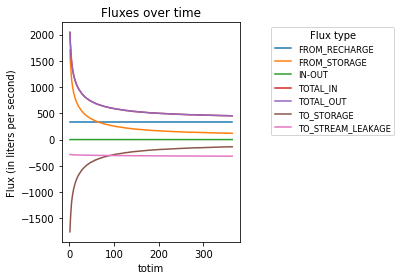

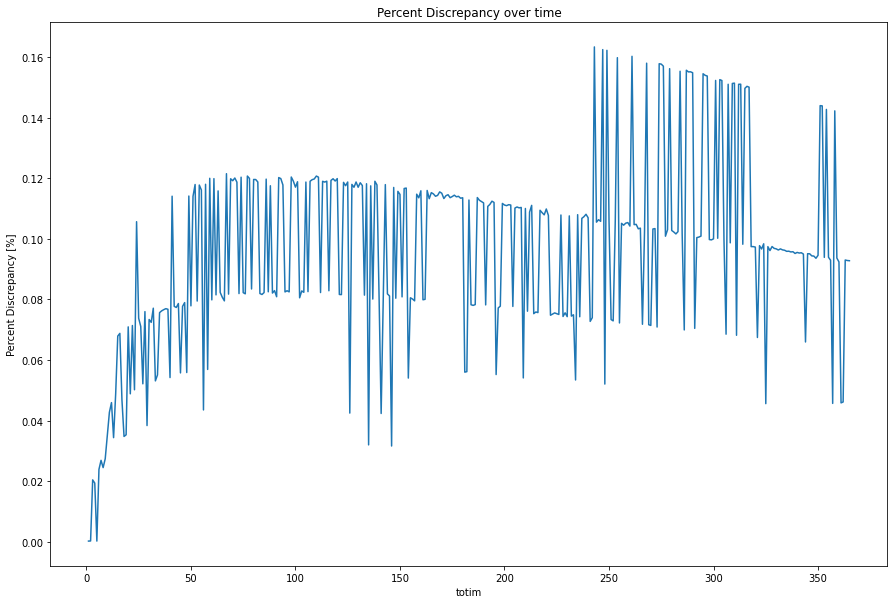

In [6]:
# Load the CSV file into a DataFrame
df = pd.read_csv(f_out)

# Pivot the DataFrame so that each 'name' becomes a column
df_pivot = df.pivot(index='totim', columns='name', values='ZONE_1')

# Apply the transformations
df_pivot = df_pivot.apply(lambda x: (x * 0.011574) if x.name != 'PERCENT_DISCREPANCY' else x )
df_pivot = df_pivot.apply(lambda x: x * -1 if 'TO_' in x.name else x)

# Drop columns that only contain zeros, except 'PERCENT_DISCREPANCY'
df_pivot = df_pivot.loc[:, (df_pivot != 0).any(axis=0) | (df_pivot.columns == 'PERCENT_DISCREPANCY')]

# Plot all columns (except 'PERCENT_DISCREPANCY') on the same plot
plt.figure(figsize=(15, 10))  # Adjust the size of the figure
df_pivot.drop(columns='PERCENT_DISCREPANCY').plot(kind='line')

plt.title('Fluxes over time')
plt.xlabel('totim')
plt.ylabel('Flux (in liters per second)')
plt.legend(title='Flux type', bbox_to_anchor=(1.15, 1), loc='upper left', fontsize='small')  # Adjust the size of the legend
plt.tight_layout()
plt.show()

# Plot 'PERCENT_DISCREPANCY' on a separate plot
plt.figure(figsize=(15, 10))  # Adjust the size of the figure
df_pivot['PERCENT_DISCREPANCY'].plot(kind='line')

plt.title('Percent Discrepancy over time')
plt.xlabel('totim')
plt.ylabel('Percent Discrepancy [%]')
plt.show()

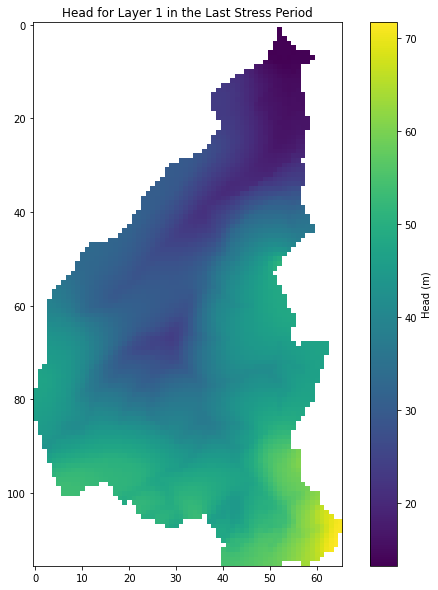

In [7]:


# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get the head for the last stress period and time step
head = hds.get_data(kstpkper=(17, 364))

# Mask values lower than -900
head = np.ma.masked_where(head < -900, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


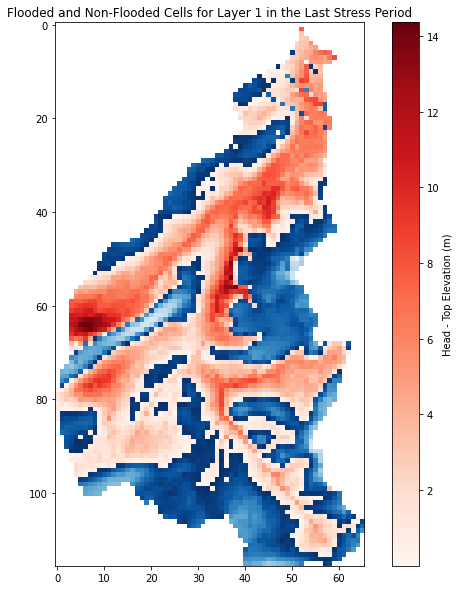

In [8]:
# Load the model
model = flopy.modflow.Modflow.load('Gondebeek.nam')  # replace 'Gondebeek_SS.nam' with your model name

# Get the top elevation of the cells
top = model.dis.top.array

# Calculate the difference between the head and the top elevation
diff = head[1, :, :] - top

# Create a mask for the flooded cells (where the difference is positive)
flooded = np.ma.masked_where(diff <= 0, diff)

# Create a mask for the non-flooded cells (where the difference is zero or negative)
non_flooded = np.ma.masked_where(diff > 0, diff)

# Plot the non-flooded cells in blue and the flooded cells in red
plt.figure(figsize=(10, 10))
plt.imshow(non_flooded, cmap='Blues', interpolation='none')
plt.imshow(flooded, cmap='Reds', interpolation='none')
plt.colorbar(label='Head - Top Elevation (m)')
plt.title('Flooded and Non-Flooded Cells for Layer 1 in the Last Stress Period')
plt.show()

In [9]:
# Load the model
modelname = 'Gondebeek'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the modelgrid from the model
modelgrid = sim.modelgrid

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(sim, modelgrid=modelgrid, vertical_exageration=10,binary=False)

# Flatten the entire 3D array of bottom elevations
botm_flattened = sim.dis.botm.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(botm_flattened, "botm")

# Calculate the top elevations
botm = sim.dis.botm.array
top = np.empty_like(botm)
top[0] = sim.dis.top.array
top[1:] = botm[:-1]

# Flatten the entire 3D array of top elevations
top_flattened = top.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(top_flattened, "top")

# Flatten the entire 3D array of hydraulic conductivity
hk_flattened = sim.upw.hk.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(hk_flattened, "hk")

# Flatten the entire 3D array of specific storage
ss_flattened = sim.upw.ss.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ss_flattened, "ss")

# Flatten the entire 3D array of specific yield
sy_flattened = sim.upw.sy.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(sy_flattened, "sy")

# Flatten the entire 3D array of ibound
ibound_flattened = sim.bas6.ibound.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ibound_flattened, "ibound")

# Write the VTK object to a file
vtkobj.write("model_SS.vtk")



In [10]:
import numpy as np
import pyvista as pv
from flopy.utils.binaryfile import HeadFile

# Load the head data
headobj = HeadFile('Gondebeek.hds')  # Replace 'model.hds' with the path to your head file
head = headobj.get_data()

# Extract the last time step
last_time_step = head[-1]

# Check if last_time_step is a 3D array
if len(last_time_step.shape) != 3:
    print("Error: last_time_step is not a 3D array.")
else:
    # Select the top layer
    top_layer = last_time_step[0]

    # Check if top_layer is a 2D array
    if len(top_layer.shape) != 2:
        print("Error: top_layer is not a 2D array.")
    else:
        # Create a mesh grid for x and y coordinates
        x, y = np.meshgrid(np.arange(top_layer.shape[1]), np.arange(top_layer.shape[0]))
        z = top_layer  # Use the head values as the z-coordinate

        # Create a 3D structured grid
        grid = pv.StructuredGrid(x, y, z)

        # Add the head data as point data to the grid
        grid.point_data["heads"] = top_layer.flatten(order="F")  # Flatten the array in column-major (Fortran-style) order

        # Save the grid to a VTK file
        grid.save("heads_last_SP_top_layer_3D.vtk")



Error: last_time_step is not a 3D array.


In [11]:
# Set the backend for PyVista
pv.set_jupyter_backend('trame')

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# List all available point data
print(thresholded_mesh)

# Plot the thresholded mesh with a specific property
# Replace 'property_name' with the name of the property you want to visualize
thresholded_mesh.plot(scalars='hk', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_SS_act.vtk")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\trame\ui\__init__.py:1: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame.ui')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\pkg_resources\__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


UnstructuredGrid (0x2499542e9a0)
  N Cells:    17392
  N Points:   139136
  X Bounds:   1.051e+05, 1.117e+05
  Y Bounds:   1.770e+05, 1.885e+05
  Z Bounds:   -2.823e+02, 7.836e+02
  N Arrays:   6


Widget(value='<iframe src="http://localhost:60190/index.html?ui=P_0x249953d64f0_0&reconnect=auto" class="pyvis…